In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
# from GaussianMixture import GaussianMixture


# Load Dataset

In [2]:

np.random.seed(42)


dataset_path = './att-database-of-faces'

data = []
labels = []

for subject_id in range(1, 41): 
    subject_path = os.path.join(dataset_path, f's{subject_id}')
    for image_name in sorted(os.listdir(subject_path)):
        image_path = os.path.join(subject_path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_flat = img.flatten()
        data.append(img_flat)
        labels.append(subject_id)

# Convert to numpy arrays
D = np.array(data)        
y = np.array(labels)       

print(f'Data matrix D shape: {D.shape}')
print(f'Label vector y shape: {y.shape}')

Data matrix D shape: (400, 10304)
Label vector y shape: (400,)


# Split the Dataset

In [3]:
train_indices = []
test_indices = []

for i in range(0, D.shape[0], 10):
    # For each subject, 10 images
    train_indices.extend([i, i+2, i+4, i+6, i+8])  # odd indexes
    test_indices.extend([i+1, i+3, i+5, i+7, i+9]) # even indexes

X_train = D[train_indices]
y_train = y[train_indices]
X_test = D[test_indices]
y_test = y[test_indices]

print(f'Train set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')


Train set shape: (200, 10304)
Test set shape: (200, 10304)


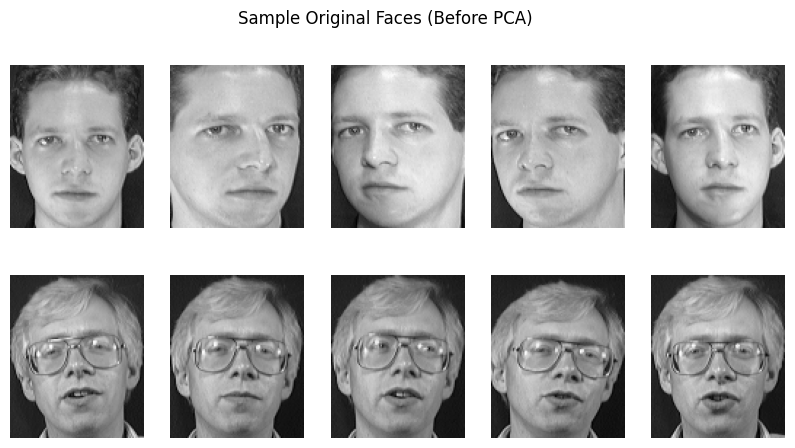

In [4]:
def plot_original_faces(X, title="Original Faces"):
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(X[i].reshape(112, 92), cmap='gray')  
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_original_faces(X_train, "Sample Original Faces (Before PCA)")


# PCA from scratch

In [5]:
class PCA_scratch:
    def __init__(self):
        self.mean = None
        self.components = None
        self.explained_variance_ratio = None

    def fit(self, X):
        # 1. Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # 2. Compute covariance matrix
        covariance_matrix = np.cov(X_centered, rowvar=False)
        
        # 3. Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        # 4. Sort eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        self.components = eigenvectors
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues / total_variance

    def transform(self, X, variance_threshold=0.9):
        X_centered = X - self.mean
        cumulative_variance = np.cumsum(self.explained_variance_ratio)
        n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
        W = self.components[:, :n_components]  # Take top eigenvectors
        return X_centered @ W, n_components

pca = PCA_scratch()
pca.fit(X_train)


alphas = [0.8, 0.85, 0.9, 0.95]
X_train_pca = {}

for alpha in alphas:
    X_reduced, n_components = pca.transform(X_train, variance_threshold=alpha)
    X_train_pca[alpha] = X_reduced
    print(f'Alpha {alpha}: reduced dimensionality = {n_components} components')

Alpha 0.8: reduced dimensionality = 36 components
Alpha 0.85: reduced dimensionality = 52 components
Alpha 0.9: reduced dimensionality = 76 components
Alpha 0.95: reduced dimensionality = 115 components


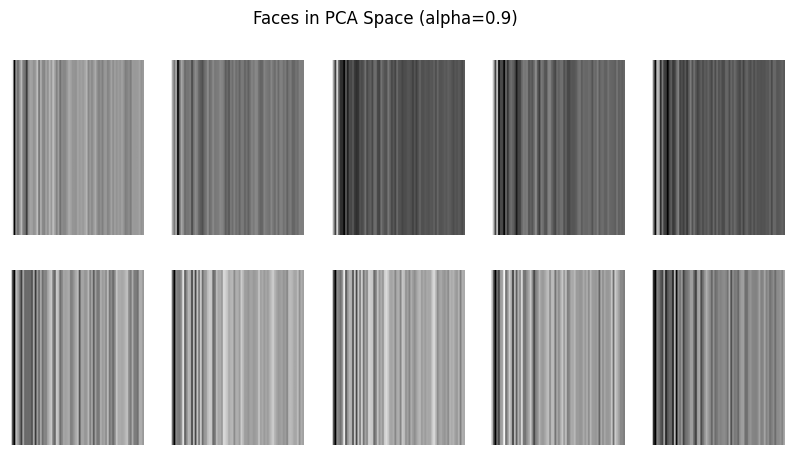

In [6]:
def plot_sample_faces(X_pca, title):
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(X_pca[i].reshape(1, -1), cmap='gray', aspect='auto')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Example for alpha = 0.9
plot_sample_faces(X_train_pca[0.9], "Faces in PCA Space (alpha=0.9)")

In [7]:
# from sklearn.decomposition import PCA
# def apply_pca(X, variance_threshold=0.9):
#     pca = PCA()
#     pca.fit(X)
    
#     # Cumulative explained variance
#     cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
#     # Find number of components to retain the given variance
#     n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
#     # Apply PCA with the found number of components
#     pca = PCA(n_components=n_components)
#     X_reduced = pca.fit_transform(X)
    
#     return X_reduced, pca

# # Try for alpha = 0.8
# alphas = [0.8, 0.85, 0.9, 0.95]
# pca_models = {}
# X_train_pca = {}

# for alpha in alphas:
#     X_reduced, pca_model = apply_pca(X_train, variance_threshold=alpha)
#     pca_models[alpha] = pca_model
#     X_train_pca[alpha] = X_reduced
#     print(f'Alpha {alpha}: reduced dimensionality = {X_reduced.shape[1]} components')

# # --- Optional: Visualize a few images in PCA space ---
# def plot_sample_faces(X_pca, title):
#     plt.figure(figsize=(10,5))
#     for i in range(10):
#         plt.subplot(2,5,i+1)
#         plt.imshow(X_pca[i].reshape(1,-1), cmap='gray', aspect='auto')
#         plt.axis('off')
#     plt.suptitle(title)
#     plt.show()

# # Example for alpha = 0.9
# plot_sample_faces(X_train_pca[0.9], "Faces in PCA Space (alpha=0.9)")

# Kmeans

In [8]:
class KMeans_scratch:
    def __init__(self, n_clusters=10, max_iter=300, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None

    def fit(self, X):
        np.random.seed(self.random_state)
        # Randomly initialize centroids
        random_indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iter):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            # Compute new centroids
            new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else self.centroids[i] 
                                      for i in range(self.n_clusters)])

            # Check for convergence
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

        self.labels_ = labels

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)


In [9]:
k_values = [20, 40, 60]
kmeans_results = {}

for alpha in alphas:  
    X_reduced = X_train_pca[alpha]
    for k in k_values:
        kmeans = KMeans_scratch(n_clusters=k)
        kmeans.fit(X_reduced)
        labels = kmeans.labels_
        kmeans_results[(alpha, k)] = labels
        print(f'KMeans done for alpha={alpha}, K={k}')


KMeans done for alpha=0.8, K=20
KMeans done for alpha=0.8, K=40
KMeans done for alpha=0.8, K=60
KMeans done for alpha=0.85, K=20
KMeans done for alpha=0.85, K=40
KMeans done for alpha=0.85, K=60
KMeans done for alpha=0.9, K=20
KMeans done for alpha=0.9, K=40
KMeans done for alpha=0.9, K=60
KMeans done for alpha=0.95, K=20
KMeans done for alpha=0.95, K=40
KMeans done for alpha=0.95, K=60


In [10]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def clustering_accuracy(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Find the best matching between clusters and true labels
    row_ind, col_ind = linear_sum_assignment(-cm)
    accuracy = cm[row_ind, col_ind].sum() / np.sum(cm)
    return accuracy


In [11]:
accuracies = {}

for (alpha, k), labels in kmeans_results.items():
    acc = clustering_accuracy(y_train, labels)  # assuming y_train is your label vector
    accuracies[(alpha, k)] = acc
    print(f'Accuracy for alpha={alpha}, K={k}: {acc:.4f}')


Accuracy for alpha=0.8, K=20: 0.4350
Accuracy for alpha=0.8, K=40: 0.6150
Accuracy for alpha=0.8, K=60: 0.6550
Accuracy for alpha=0.85, K=20: 0.4250
Accuracy for alpha=0.85, K=40: 0.5900
Accuracy for alpha=0.85, K=60: 0.6550
Accuracy for alpha=0.9, K=20: 0.4250
Accuracy for alpha=0.9, K=40: 0.5800
Accuracy for alpha=0.9, K=60: 0.6700
Accuracy for alpha=0.95, K=20: 0.4150
Accuracy for alpha=0.95, K=40: 0.5850
Accuracy for alpha=0.95, K=60: 0.6650


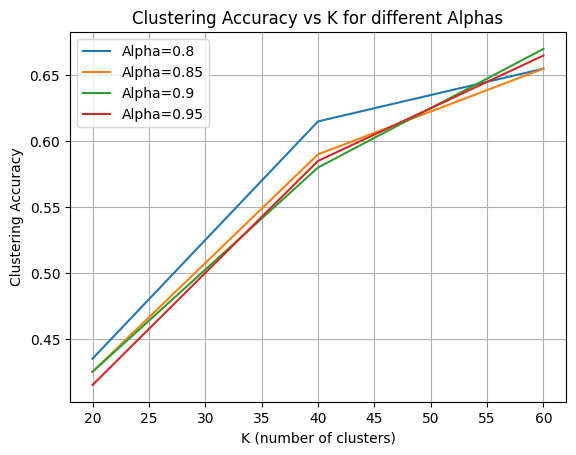

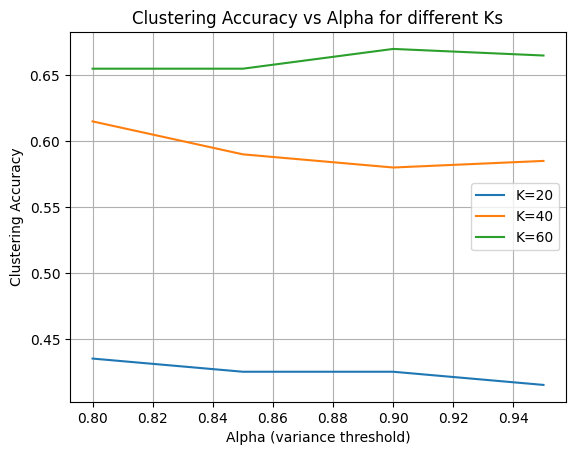

In [12]:
import matplotlib.pyplot as plt

# Accuracy vs K (for each alpha)
for alpha in alphas:
    acc = [accuracies[(alpha, k)] for k in k_values]
    plt.plot(k_values, acc, label=f'Alpha={alpha}')

plt.xlabel('K (number of clusters)')
plt.ylabel('Clustering Accuracy')
plt.title('Clustering Accuracy vs K for different Alphas')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy vs alpha (for each K)
for k in k_values:
    acc = [accuracies[(alpha, k)] for alpha in alphas]
    plt.plot(alphas, acc, label=f'K={k}')

plt.xlabel('Alpha (variance threshold)')
plt.ylabel('Clustering Accuracy')
plt.title('Clustering Accuracy vs Alpha for different Ks')
plt.legend()
plt.grid(True)
plt.show()


# GMM

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal


class GaussianMixture:
    def __init__(self, n_components=2, max_iter=100, tol=1e-4, reg_covar=1e-6, n_init=1, seed=None):
        
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.n_init = n_init
        self.seed = seed
        
        # Model parameters
        self.weights = None
        self.means = None
        self.covariances = None
        self.log_likelihood_history = []
        self.converged = False
        
    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape
        
        # Randomly select data points as initial means (same as sklearn)
        rng = np.random.RandomState(self.seed)
        indices = rng.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices].copy()
        
        # Compute distances to first mean
        resp = np.zeros((n_samples, self.n_components))
        squared_norm = np.sum(X ** 2, axis=1)
        
        for k in range(self.n_components):
            diff = X - self.means[k]
            dist = squared_norm - 2 * np.dot(X, self.means[k]) + np.sum(self.means[k] ** 2)
            resp[:, k] = dist
            
        resp = 1 / (1 + resp)  # Convert distance to responsibility
        resp = resp / resp.sum(axis=1, keepdims=True)  # Normalize
            
        # Initialize weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components
        
        # Initialize covariances with responsibility-weighted covariance
        self.covariances = np.zeros((self.n_components, n_features, n_features))
        
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = np.dot(resp[:, k] * diff.T, diff) / resp[:, k].sum()
            
            # Add regularization
            self.covariances[k].flat[::n_features + 1] += self.reg_covar
    
    def _e_step(self, X):
        n_samples = X.shape[0]
        
        # Initialize log responsibility matrix
        weighted_log_prob = np.zeros((n_samples, self.n_components))
        
        # Compute log probability and responsibilities for each component
        for k in range(self.n_components):
            try:
                # Direct computation without scipy for speed
                log_det = np.linalg.slogdet(self.covariances[k])[1]
                prec = np.linalg.inv(self.covariances[k])
                
                # Log probabilities using multivariate normal formula
                n_features = X.shape[1]
                log_prob = -0.5 * (n_features * np.log(2 * np.pi) + log_det)
                
                for i in range(n_samples):
                    diff = X[i] - self.means[k]
                    log_prob_i = log_prob - 0.5 * diff @ prec @ diff
                    weighted_log_prob[i, k] = np.log(self.weights[k]) + log_prob_i
                    
            except np.linalg.LinAlgError:
                # Fallback to scipy's implementation with allow_singular=True
                rv = multivariate_normal(
                    mean=self.means[k], 
                    cov=self.covariances[k],
                    allow_singular=True
                )
                log_prob = rv.logpdf(X)
                weighted_log_prob[:, k] = np.log(self.weights[k]) + log_prob
        
        # Log-sum-exp trick for numerical stability
        log_prob_norm = logsumexp(weighted_log_prob, axis=1)
        log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
        
        # Store log likelihood for convergence check
        self.log_likelihood_history.append(np.mean(log_prob_norm))
        
        return np.exp(log_resp)
    
    def _m_step(self, X, resp):
        n_samples, n_features = X.shape
        
        # Update weights
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        self.weights = nk / n_samples
        
        # Update means
        self.means = np.dot(resp.T, X) / nk[:, np.newaxis]
        
        # Update covariances
        for k in range(self.n_components):
            diff = X - self.means[k]
            weighted_diff = diff * np.sqrt(resp[:, k])[:, np.newaxis]
            cov_k = np.dot(weighted_diff.T, weighted_diff) / nk[k]
            
            # Ensure symmetry
            cov_k = (cov_k + cov_k.T) / 2
            
            # Add regularization (similar to sklean's reg_covar parameter)
            cov_k.flat[::n_features + 1] += self.reg_covar
            
            self.covariances[k] = cov_k
    
    def _check_convergence(self, iteration):
        if len(self.log_likelihood_history) < 2:
            return False
            
        ll_diff = self.log_likelihood_history[-1] - self.log_likelihood_history[-2]
        return abs(ll_diff) < self.tol
    
    def fit(self, X):
        X = np.asarray(X)
        best_ll = -np.inf
        best_params = None
        
        for init in range(self.n_init):
            if self.seed is not None:
                seed = self.seed + init
            else:
                seed = None
                
            self.log_likelihood_history = []
            self._initialize_parameters(X)
            
            for iteration in range(self.max_iter):
                # E-step
                resp = self._e_step(X)
                
                # M-step
                self._m_step(X, resp)
                
                # Check for convergence
                if self._check_convergence(iteration):
                    self.converged = True
                    print(f"Converged at iteration {iteration+1}")
                    break
                    
                if (iteration + 1) % 10 == 0:
                    print(f"Iteration {iteration+1}/{self.max_iter}, "
                          f"log-likelihood: {self.log_likelihood_history[-1]:.4f}")
            
            # Keep track of best result
            if self.log_likelihood_history and self.log_likelihood_history[-1] > best_ll:
                best_ll = self.log_likelihood_history[-1]
                best_params = {
                    'weights': self.weights.copy(),
                    'means': self.means.copy(),
                    'covariances': self.covariances.copy(),
                    'log_likelihood': self.log_likelihood_history,
                    'converged': self.converged
                }
                
        # Set parameters to best result
        if best_params:
            self.weights = best_params['weights']
            self.means = best_params['means']
            self.covariances = best_params['covariances'] 
            self.log_likelihood_history = best_params['log_likelihood']
            self.converged = best_params['converged']
            
        return self
    
    def predict_proba(self, X):
        X = np.asarray(X)
        resp = self._e_step(X)
        return resp
    
    def predict(self, X):
        X = np.asarray(X)
        resp = self.predict_proba(X)
        return np.argmax(resp, axis=1)
    
    def score_samples(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        scores = np.zeros(n_samples)
        
        for k in range(self.n_components):
            try:
                rv = multivariate_normal(
                    mean=self.means[k],
                    cov=self.covariances[k],
                    allow_singular=True
                )
                scores += self.weights[k] * np.exp(rv.logpdf(X))
            except:
                # Skip this component if there's an error
                continue
                
        return np.log(scores)


def logsumexp(a, axis=None):
    a_max = np.amax(a, axis=axis, keepdims=True)
    
    if a_max.ndim > 0:
        a_max[~np.isfinite(a_max)] = 0
    elif not np.isfinite(a_max):
        a_max = 0
        
    tmp = np.exp(a - a_max)
    
    with np.errstate(divide='ignore'):
        s = np.sum(tmp, axis=axis)
        out = np.log(s)
        
    a_max = np.squeeze(a_max, axis=axis)
    out += a_max
    
    return out

In [55]:
gmm_results = {}

for alpha in alphas:  
    X_reduced = X_train_pca[alpha]
    for k in k_values:
        gmm = GaussianMixture(n_components=k, max_iter=100, seed=42)
        gmm.fit(X_reduced)
        labels = gmm.predict(X_reduced)
        gmm_results[(alpha, k)] = labels
        print(f'GMM done for alpha={alpha}, K={k}')

Converged at iteration 7
GMM done for alpha=0.8, K=20
Converged at iteration 6
GMM done for alpha=0.8, K=40
Converged at iteration 7
GMM done for alpha=0.8, K=60
Converged at iteration 6
GMM done for alpha=0.85, K=20
Converged at iteration 7
GMM done for alpha=0.85, K=40
Converged at iteration 6
GMM done for alpha=0.85, K=60
Converged at iteration 5
GMM done for alpha=0.9, K=20
Converged at iteration 6
GMM done for alpha=0.9, K=40
Converged at iteration 6
GMM done for alpha=0.9, K=60
Converged at iteration 6
GMM done for alpha=0.95, K=20
Converged at iteration 6
GMM done for alpha=0.95, K=40
Converged at iteration 7
GMM done for alpha=0.95, K=60


In [56]:
gmm_accuracies = {}

for (alpha, k), labels in gmm_results.items():
    acc = clustering_accuracy(y_train, labels)
    gmm_accuracies[(alpha, k)] = acc
    print(f'GMM Accuracy for alpha={alpha}, K={k}: {acc:.4f}')


GMM Accuracy for alpha=0.8, K=20: 0.4300
GMM Accuracy for alpha=0.8, K=40: 0.6150
GMM Accuracy for alpha=0.8, K=60: 0.6650
GMM Accuracy for alpha=0.85, K=20: 0.4150
GMM Accuracy for alpha=0.85, K=40: 0.6050
GMM Accuracy for alpha=0.85, K=60: 0.6250
GMM Accuracy for alpha=0.9, K=20: 0.4050
GMM Accuracy for alpha=0.9, K=40: 0.6100
GMM Accuracy for alpha=0.9, K=60: 0.6350
GMM Accuracy for alpha=0.95, K=20: 0.4100
GMM Accuracy for alpha=0.95, K=40: 0.6050
GMM Accuracy for alpha=0.95, K=60: 0.6400


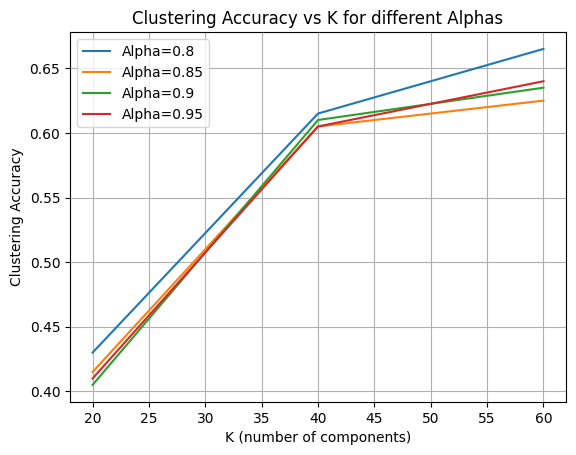

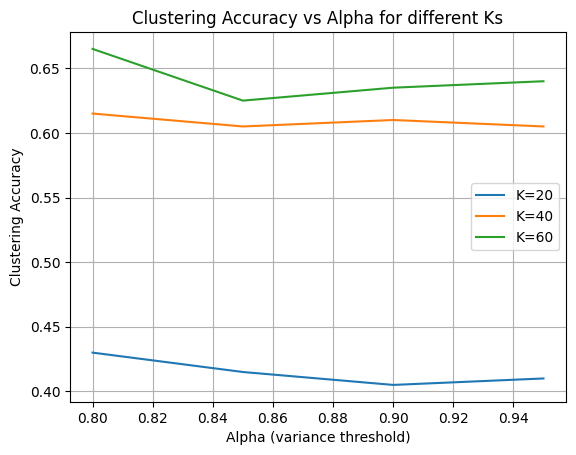

In [57]:
import matplotlib.pyplot as plt

# Accuracy vs K (for each alpha)
for alpha in alphas:
    acc = [gmm_accuracies[(alpha, k)] for k in k_values]
    plt.plot(k_values, acc, label=f'Alpha={alpha}')

plt.xlabel('K (number of components)')
plt.ylabel('Clustering Accuracy')
plt.title('Clustering Accuracy vs K for different Alphas')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy vs alpha (for each K)
for k in k_values:
    acc = [gmm_accuracies[(alpha, k)] for alpha in alphas]
    plt.plot(alphas, acc, label=f'K={k}')

plt.xlabel('Alpha (variance threshold)')
plt.ylabel('Clustering Accuracy')
plt.title('Clustering Accuracy vs Alpha for different Ks')
plt.legend()
plt.grid(True)
plt.show()


# Bonus not finished yet

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim=10304, bottleneck_dim=50):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, bottleneck_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()  # output in [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


ModuleNotFoundError: No module named 'torch'

In [ ]:
# Normalize pixel values to [0,1]
X_train_norm = X_train / 255.0

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = X_train_tensor.to(device)


In [ ]:
# Instantiate model
autoencoder = Autoencoder(input_dim=10304, bottleneck_dim=50).to(device)

# Optimizer and Loss
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training loop
epochs = 100
batch_size = 64

print("Training Autoencoder...")
for epoch in range(epochs):
    permutation = torch.randperm(X_train_tensor.size()[0])
    
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch = X_train_tensor[indices]
        
        # Forward pass
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")


In [ ]:
# Switch to evaluation mode
autoencoder.eval()

# Extract bottleneck features
with torch.no_grad():
    features = autoencoder.encoder(X_train_tensor).cpu().numpy()

print(f"Bottleneck features shape: {features.shape}")  


In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

# Apply K-Means
kmeans = KMeans(n_clusters=40, random_state=42)
kmeans_labels = kmeans.fit_predict(features)

# Apply GMM
gmm = GaussianMixture(n_components=40, random_state=42)
gmm_labels = gmm.fit_predict(features)



print("K-Means clustering done.")
print("GMM clustering done.")


In [ ]:
# Reconstruct some images
with torch.no_grad():
    reconstructed = autoencoder(X_train_tensor).cpu().numpy()

def plot_reconstructed_faces(originals, reconstructed, title="Reconstructed Faces"):
    plt.figure(figsize=(20, 5))
    for i in range(10):
        # Original
        plt.subplot(2, 10, i+1)
        plt.imshow(originals[i].reshape(112,92), cmap='gray')
        plt.axis('off')
        
        # Reconstructed
        plt.subplot(2, 10, i+11)
        plt.imshow(reconstructed[i].reshape(112,92), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_reconstructed_faces(X_train_norm, reconstructed, title="Original vs Reconstructed Faces (Autoencoder)")
